## Enron DLP Gateway Policy Enforcer

Sagi Vaknin

# Imports and Data retrieval

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import email
import re
import pickle

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import warnings

import spacy
from multiprocessing import Pool
from collections import defaultdict

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


db = pd.read_pickle("./enron_students.pkl")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sagivaknin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sagivaknin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sagivaknin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Loading

In [73]:
main_df = pd.DataFrame(db)

# Exploratory Data Analysis (EDA)

Initial data exploration

In [3]:
main_df.head(1)

,Date,From,To,X-To,X-From,X-cc,X-bcc,Subject,email_body,verdict,violated_rules
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Tim Belden <Tim Belden/Enron@EnronXGate>,Phillip K Allen,,,,Here is our forecast\n\n,ALLOW,


In [4]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Date            517401 non-null  object
 1   From            517401 non-null  object
 2   To              495554 non-null  object
 3   X-To            517372 non-null  object
 4   X-From          517372 non-null  object
 5   X-cc            517372 non-null  object
 6   X-bcc           517372 non-null  object
 7   Subject         517401 non-null  object
 8   email_body      517401 non-null  object
 9   verdict         517401 non-null  object
 10  violated_rules  517401 non-null  object
dtypes: object(11)
memory usage: 43.4+ MB


In [5]:
main_df.describe()

,Date,From,To,X-To,X-From,X-cc,X-bcc,Subject,email_body,verdict,violated_rules
count,517401,517401,495554,517372,517372,517372,517372,517401,517401,517401,517401
unique,224128,20328,58563,73552,27980,33701,132,159290,249025,2,29
top,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",kay.mann@enron.com,pete.davis@enron.com,,Kay Mann,,,,"As you know, Enron Net Works (ENW) and Enron G...",ALLOW,
freq,1118,16735,9155,9124,16324,388486,517197,19187,112,461908,461908


Plotting common words to identify irrelevant words which spam the data

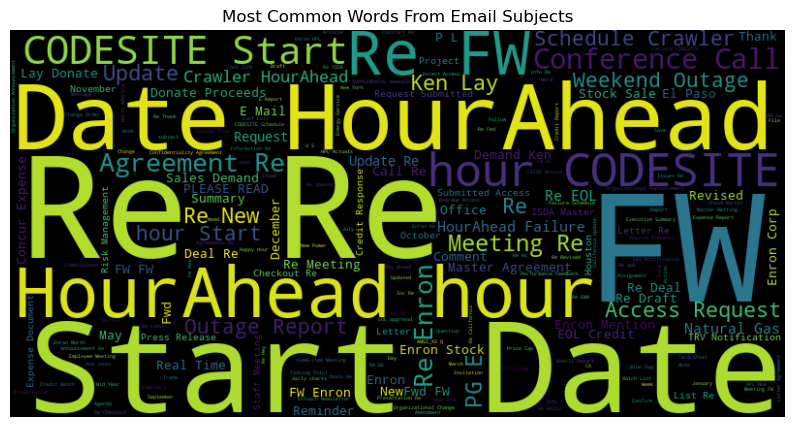

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

subject_text = ' '.join(subject for subject in main_df['Subject'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(subject_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words From Email Subjects')
plt.show()

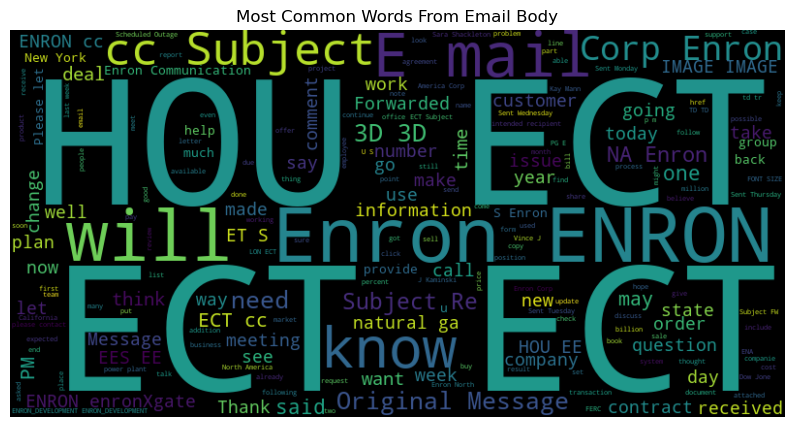

In [7]:
random_email_batch = main_df.sample(n=100000, random_state=123) #using a smaller batch of mails for quicker runtime

email_text = ' '.join(word for word in random_email_batch['email_body'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(email_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words From Email Body')
plt.show()

Plot Email Lengths Distribution

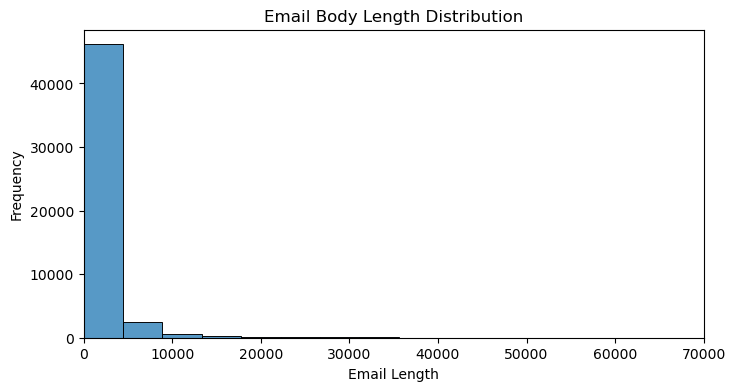

In [74]:
def plot_email_length_dist(df):

  lengths = df['email_body'].apply(len).tolist()

  plt.figure(figsize=(8, 4))
  sns.histplot(lengths, bins=60)
  plt.title('Email Body Length Distribution')
  plt.xlabel('Email Length')
  plt.ylabel('Frequency')
  plt.xlim(0, 70000)
  plt.show()

sample_df = main_df.sample(n=50000, random_state=42)
plot_email_length_dist(sample_df)

Determine Allow vs. Block precentages in given dataframe

In [8]:
verdict_counts = main_df['verdict'].value_counts()
print(f"There are {verdict_counts['ALLOW']} emails who've passed")
print(f"There are {verdict_counts['BLOCK']} emails who've got blocked")
print(f'The percentage of BLOCKED emails in the given dataframe is {round( (verdict_counts["BLOCK"] / verdict_counts["ALLOW"]) * 100, 3)}%')

There are 461908 emails who've passed
There are 55493 emails who've got blocked
The percentage of BLOCKED emails in the given dataframe is 12.014%


# Data preprocessing

In [3]:
def clean(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(('from', 'to', 'cc', 'mailto', 'http', 're', 'www', 'com', 'subject', 'sent', 'email', 'u', 'ok', 'thanks', 'please', 'ect',
                       'dt', 'pm', 'forward', 'e', 'thank', 'forwarded', 'would', 'said', 'enron', 'corp', 'attached', 'sara', 'also',
                       'smith', 'need', 'mail', 'message', "subject", "original", "email", "fw", "date", "draft", "reminder"))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    if len(text) > 10000:
        return []
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop_words) and (not i.isdigit()) and len(i)>3)])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())

    return normalized.split()

In [4]:
def preprocess_df(df):
  temp_df = df.copy()
  temp_df["combined"] = temp_df["Subject"] + " " + temp_df["email_body"]
  temp_df = temp_df.drop(["X-cc", "X-bcc", "Date", "Subject", "email_body"], axis=1)
  temp_df["email_content"] = temp_df["combined"].apply(clean)

  return temp_df

# Rule-based Content Analysis

In [5]:
def apply_rule_based(row):
  regexes = {"has_ssn" : r'\d{3}-?\d{2}-?\d{4}',
            "has_ip" : r'(?:[0-9]{1,3}\.){3}[0-9]{1,3}',
            "has_credit_card" : r'((4\d{3})|(5[1-5]\d{2}))(-?|\040?)(\d{4}(-?|\040?)){3}|^(3[4,7]\d{2})(-?|\040?)\d{6}(-?|\040?)\d{5}',
            "has_phone" : r'\b[2-9][0-9]{2} [2-9][0-9]{2} [0-9]{4}\b|\b[2-9][0-9]{2}-[2-9][0-9]{2}-[0-9]{4}\b|\([2-9][0-9]{2}\) [2-9][0-9]{2} [0-9]{4}\b|\([2-9][0-9]{2}\)[2-9][0-9]{6}\b|\([2-9][0-9]{2}\) ?[2-9][0-9]{2}-[0-9]{4}\b|\b[2-9][0-9]{2}-[2-9][0-9]{2}-[0-9]{4}\b|x\d+-\d{4}|\d{3}\.\d{3}\.\d{4}|\d{3} \d{3}-\d{4}|\d+-\d{4}|x\d{5}',
             "has_address" : r'[a-zA-Z]+(?:\s+[a-zA-Z]+)*,\s+[A-Z]{2}\s+\d{5}'
            }

  text = row['combined']
  for regex in regexes.values():
      if re.search(regex, text):
          return True

  not_allowed_keywords = ["password", "username", "user name", "pass word", "pipe code", "rate zone", "conference room", "user id", "pool id"]
  for na_keyword in not_allowed_keywords:
    if na_keyword in text.lower():
      return True

  return False

# NER Content Analysis

In [7]:
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger"])

def extract_entities(text):
    """Extract entities from a document and return them with the original text."""
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def ner_clean(text):
  stop_words = set(stopwords.words('english'))
  stop_words.update(('from', 'to', 'cc', 'mailto', 'http', 're', 'www', 'com', 'subject', 'sent', 'email', 'u', 'ok', 'thanks', 'please', 'ect',
                       'dt', 'pm', 'forward', 'e', 'thank', 'forwarded', 'would', 'said', 'enron', 'corp', 'attached', 'sara', 'also',
                       'smith', 'need', 'mail', 'message', "subject", "original", "email", "fw", "date", "draft", "reminder"))
  exclude = set(string.punctuation)
  lemma = WordNetLemmatizer()
  porter= PorterStemmer()

  if len(text) > 10000:
     return ""
  
  text=text.rstrip()
  stop_free = " ".join([i for i in text.lower().split() if((i not in stop_words) and len(i)>3)])
  punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
  normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
  # stem = " ".join(porter.stem(token) for token in normalized.split())

  return normalized

def build_ner_dict(entity_list):
  entity_dict = defaultdict(list)
  for entity, entity_type in entity_list:
    entity_dict[entity_type].append(entity)

  return dict(entity_dict)

In [8]:
def run_ner(df):
  temp_df = df.copy()
  temp_df["ner_cleaned"] = temp_df["combined"].apply(ner_clean)
  temp_df['entities'] = temp_df['ner_cleaned'].apply(extract_entities)
  temp_df["entities"] = temp_df["entities"].apply(build_ner_dict)

  return temp_df

In [9]:
def apply_content_analysis(df):
  temp_df = df.copy()
  temp_df = preprocess_df(temp_df)
  temp_df["has_pii_qid"] = temp_df.apply(apply_rule_based, axis = 1) #rule based
  temp_df = run_ner(temp_df) #ner
  return temp_df

# Keyword Analysis Topic Modeling

In [10]:
def keyword_analysis(text):
  topics = {
      "legal": ["litigation", "defendant", "law", "court", "attorney", "legal", "lawyer", "sue", "suit", "lawsuit", "verdict", "appeal", "illegally", "representative", "filed", "ban", "banning",
                "government", "political", "politics", "politic","legality", "illegality", "jurisdiction", "testimony", "arbitration", "problem", "amendment", "document", "committee", "manipulation",
                "deposition", "tort", "document", "contract", "compliance", "regulation", "patent", "trademark", "infringement", "deal", "agreement", "counterparty", "investigation", "investigate",
                "counsel", "solicitor", "settlement", "legislation", "rights", "mediation", "subpoena", "judge", "legislative", "pledge", "covenant", "represented", "misrepresented", "representing"],

      "financial": ["revenue", "budget", "financial", "cost", "profit", "price", "invest", "money", "invoice", "offer", "hedge", "hedgefund", "trader", "pretax", "purchasing", "accumulate", "compensation",
                    "loss", "asset", "liability", "equity", "portfolio", "dollar", "pay", "funds", "transaction", "lease", "beneficial", "cash", "billion", "million", "thousand", "hundred", "dowjones",
                    "investment", "dividend", "capital", "tax", "audit", "buy", "purchase", "pricing", "priced", "interest", "share", "fund", "incentive", "nyse", "shareholder", "captial", "tariff",
                    "balance", "bankruptcy", "credit", "debt", "fiscal", "financial", "salary", "trading", "trade", "bank", "acquire", "percent", "creditor", "sale", "cent", "nickel", "dime", "quarter",
                    "shares", "stock", "bond", "finance", "accounting", "liabilities", "treasurer", "bill", "market", "profitsharing", "proceeds", "commission", "sold", "sell", "rate", "value"
                    "expensive", "cheap", "marketplace", "ecommerce", "commerce", "markup", "retail", "wholesale", "silver", "gold", "liquidity", "holding", "holdings", "meter", "budgeting", "dow", "jones"],

      "business": ["management", "strategy", "operations", "enterprise", "project", "department", "corporation", "organization", "manage", "requirements", "termination", "terminating", "departments", "growth",
                  "client", "customer", "vendor", "partner", "stakeholder", "fire", "hire", "merge", "nomination", "negotiate", "businessrelated", "procedure", "office", "offices", "companies", "account",
                  "meeting", "presentation", "conference", "agenda", "objective", "requisition", "businesses", "service", "administer", "personnel", "work", "worker", "workers", "factory", "consultant",
                  "goals", "initiative", "collaboration", "acquisition", "merger", "proposal", "customers", "requirement", "operation", "services", "industry", "administrator", "company", "employees",
                  "expansion", "innovation", "development", "growth", "negotiation", "business", "meetings", "training", "managing", "staff", "resource", "resources", "employ", "employee", "offer", "authorized"] ,


      "sensitive_business" : ["confidential", "proprietary", "trade secret", "non-disclosure", "classified", "privileged",
                              "sensitive", "secure", "privacy", "breach", "leak", "encryption", "security", "hack", "cyber",
                              "exposure", "compliance", "audit", "risk", "vulnerability", "threat", "intellectual property",
                              "restricted", "internal use", "exclusive", "discrete", "confidentiality", "prohibited", "prohibition"]
  }
  if isinstance(text, list):
    text = " ".join(text)

  topic_count = {key:0 for key in topics}
  text = "".join([ch for ch in text if ch not in string.punctuation])

  for word in text.split():
    for topic, key_words in topics.items():
      if word.lower() in key_words:
        topic_count[topic] += 1

  topics_list = []
  for topic, count in topic_count.items():
    if count > 0:
      topics_list.append(topic)

  return topics_list if topics_list != [] else ["general"]

In [11]:
def add_ner_topics(row):
  ner_dict = row["entities"]
  current_topics = row["topic"]
  topics = set(current_topics)
  if "MONEY" in ner_dict.keys() or "PERCENT" in ner_dict.keys():
    topics.add("financial")
  if "NORP" in ner_dict.keys():
    topics.add("legal")
  if "QUANTITY" in ner_dict.keys():
    topics.add("business")
  return topics


In [12]:
def apply_topic_modeling(df):
  current_df = df.copy()
  current_df["topic"] = current_df["email_content"].apply(keyword_analysis)
  current_df["topic"] = current_df.apply(add_ner_topics, axis = 1)
  current_df = current_df.drop(["entities", "ner_cleaned", ], axis=1)
  return current_df

# Personnel Dataframe Creation

In [13]:
def add_to_workers_df(worker_df, name, isEnron, rank, gpe, dept):
  curr_row = {"Name": name, "Rank": rank, "isEnron": isEnron, "GPE": gpe, "dept": dept }

  if name in worker_df['Name'].values:
      idx = worker_df.index[worker_df['Name'] == name].tolist()[0]

      if rank is not None:
          worker_df.at[idx, "Rank"] = rank
      if isEnron is not None and not worker_df[worker_df["Name"] == name].iloc[0]["isEnron"]:
          worker_df.at[idx, "isEnron"] = isEnron
      if gpe is not None:
          worker_df.at[idx, "GPE"] = gpe
      if dept is not None:
          worker_df.at[idx, "dept"] = dept
  else:
    # add new line
    worker_df = pd.concat([worker_df,  pd.DataFrame([curr_row])], ignore_index=True)

  return worker_df

def retrieve_extra_data_from(row):
  name = gpe = rank = dept = None

  if not row["X-From"]:
    return name, gpe, rank, dept

  data_from = row["X-From"].replace(",","")

  name = data_from.split("<")[0].strip()
  name = [char for char in name.lower() if char.isalpha() or char.isspace()]
  name = "".join(name)

  us_list = ["OU=NA", "OU==NA", "/NA/", "OU=HOU", "/HOU", "@HOU", "@SAF", "/SF/", "@PDX", "/PDX/", "/CAL/"]
  eu_list = ["OU=EU", "OU==EU", "/LON/", "@LON", "/DUB/", "@DUB"]

  for key in us_list:
    if key in data_from:
      gpe = "US"
      break

  if gpe != "US":
    for key in eu_list:
      if key in data_from:
        gpe = "EU"

  if "@EES" in data_from:
    dept = "EES"
  elif "@ECT" in data_from:
    dept = "ECT"

  return name, rank, gpe, dept

def retrieve_extra_data_to(mail, worker_data):
  name = gpe = rank = dept = None

  name = worker_data.split("<")[0].strip()
  name = [char for char in name.lower() if char.isalpha() or char.isspace()]
  name = "".join(name)

  us_list = ["OU=NA", "OU==NA", "/NA/", "OU=HOU", "/HOU", "@HOU", "@SAF", "/SF/", "@PDX", "/PDX/", "/CAL/"]
  eu_list = ["OU=EU", "OU==EU", "/LON/", "@LON", "/DUB/", "@DUB"]

  isEnron = "enron" in mail.lower()

  for key in us_list:
    if key in worker_data:
      gpe = "US"
      break

  if gpe != "US":
    for key in eu_list:
      if key in worker_data:
        gpe = "EU"

  if "@EES" in worker_data:
    dept = "EES"
  elif "@ECT" in worker_data:
    dept = "ECT"

  return name, isEnron, rank, gpe, dept

def build_workers_data(df, worker_df):

  to_pattern = r'(?:[a-zA-Z0-9 .\(\)*@/\',_#-&]+<.*?>?(?=, )|[a-zA-Z0-9 .\(\)@/\',_#-&]+<.*?>?(?= @ ENRON)|[a-zA-Z0-9 .\(\)@/\',_#-&]+<.*?>|[a-zA-Z0-9 ."\(\)\'-@#/&_,]+?(?=, )|[a-zA-Z0-9 ."\(\)\'-@#/&_,]+)'

  for index, row in df.iterrows():
    if row['From'] and row['X-From'] and row['To'] and row['X-To']:

      # isEnron extraction
      isEnronEmployee = "enron" in row["From"].lower()

      # extra data extraction
      name, rank, gpe, dept = retrieve_extra_data_from(row)

      worker_df = add_to_workers_df(worker_df, name, isEnronEmployee, rank, gpe, dept)
      # curr_row["Name"], curr_row["Rank"], curr_row["GPE"], curr_row["dept"] = retrieve_extra_data(row)

      to = [email.strip("\n\t") for email in row['To'].split(", ")]
      x_to = [email.replace(",", "").strip(' ,"\'.')for email in re.findall(to_pattern, row['X-To'].replace("-", " "))]

      for i, mail in enumerate(to):
        try:
          data = x_to[i]
          name, isEnronEmployee, rank, gpe, dept = retrieve_extra_data_to(mail, data)
          worker_df = add_to_workers_df(worker_df, name, isEnronEmployee, rank, gpe, dept)

        except:
          continue

  return worker_df

# Validate rule violations

In [14]:
def parse_sender(x_from_data):
  """ transform the x_from_data input to a valid
      sender value s.t will be compatible with "workers_data" dataframe search
  """
  if not x_from_data:
    return None

  data_from = x_from_data.replace(",","")
  name = data_from.split("<")[0].strip()
  name = name.replace("'", "").replace('"','')
  return name.lower()

def parse_recievers(x_to_data):
  """ transform the x_to_data input to a valid
      recievers value s.t will be compatible with workers_data dataframe search
  """
  if not x_to_data:
    return None

  to_pattern = r'(?:[a-zA-Z0-9 .\(\)*@/\',_#-&]+<.*?>?(?=, )|[a-zA-Z0-9 .\(\)@/\',_#-&]+<.*?>?(?= @ ENRON)|[a-zA-Z0-9 .\(\)@/\',_#-&]+<.*?>|[a-zA-Z0-9 ."\(\)\'-@#/&_,]+?(?=, )|[a-zA-Z0-9 ."\(\)\'-@#/&_,]+)'
  x_to = [email.replace(",", "").strip(' ,"\'.')for email in re.findall(to_pattern, x_to_data.replace("-", " "))]

  x_to = [name.split("<")[0].strip().lower().replace("'","").replace('"','') for name in x_to]

  return x_to

def check_eu_us_condition(sender, recievers):
  """ recieves mail sender and recievers, if both the sender and all the recievers
      located in the same GPE, return True else return False
  """
  sender_gpe = True
  if sender in workers_data["Name"].values:
    sender_gpe = workers_data[workers_data["Name"] == sender].iloc[0]["GPE"]

  if not sender_gpe:
    return True

  for reciever in recievers:
    if reciever in workers_data["Name"].values:
      reciever_gpe = workers_data[workers_data["Name"] == reciever].iloc[0]["GPE"]
      if reciever_gpe and sender_gpe != reciever_gpe:
        return False

  return True

def check_enron_condition(sender, recievers):
  """ check all the recievers are enron employees,
      if yes, return True, else return False
  """
  if sender in workers_data.values:
    if not workers_data[workers_data["Name"] == sender].iloc[0]["isEnron"]:
      return True
  else:
    return True

  for reciever in recievers:
    if reciever in workers_data["Name"].values:
      if not workers_data[workers_data["Name"] == reciever].iloc[0]["isEnron"]:
        return False

  return True

def check_ect_condition(sender, recievers):
  """ check both the sender and the recievers are both in ECT or both in EES,
      if yes, return True, else return False.
      (if unknown, return True also)
  """
  sender_dept = True
  if sender in workers_data["Name"].values:
    sender_dept = workers_data[workers_data["Name"] == sender].iloc[0]["dept"]

  if not sender_dept:
    return True

  for reciever in recievers:
    if reciever in workers_data["Name"].values:
      reciever_dept = workers_data[workers_data["Name"] == reciever].iloc[0]["dept"]
      if reciever_dept and sender_dept != reciever_dept:
        return False

  return True

def check_pii_qid(pii_qid_flag):
  """ if pii_qid_flag is True (means there is a pii/qid in the mail) then return False
      otherwise, return True
  """
  return not pii_qid_flag

def check_high_ranks_condition(sender, recievers):
  """ if both the sender and all the recievers hold high ranks, return True
      if no data, return True,
      otherwise, return False
  """
  if sender in workers_data["Name"].values:
    if workers_data[workers_data["Name"] == sender].iloc[0]["Rank"] == "High":
      for reciever in recievers:
        if reciever in workers_data["Name"].values:
          if reciever in workers_data[workers_data["Name"] == reciever].iloc[0] != "High":
            return False

  return True


In [15]:
def check_rule_violations(mail):

  mail_topic = mail["topic"]
  sender = parse_sender(mail["X-From"])
  if not sender or sender == "":
    sender = parse_sender(mail["From"])

  recievers = parse_recievers(mail["X-To"])

  if not recievers or recievers == "":
    recievers = parse_recievers(mail["To"])

  if not recievers or not sender:
    return []

  violations = set()
  if "financial" in mail_topic:
    # check if there is an EU-US conflict (1.2)
    if not check_eu_us_condition(sender, recievers):
      violations.add("1.2")
    # check email does not leave enron perimeter (1.3)
    if not check_enron_condition(sender, recievers):
      violations.add("1.3")
    # check if also containing PII or QID - if yes, cant leave ECT
    if not check_pii_qid(mail["has_pii_qid"]):
      if not check_ect_condition(sender, recievers):
        violations.add("2.1")
      if not check_enron_condition(sender, recievers):
        violations.add("2.3")

  if "business" in mail_topic:
    # check email does not leave enron perimeter (1.3)
    # check if containing PII or QID - if yes, cant leave ENRON
    if not check_enron_condition(sender, recievers):
      violations.add("1.3")
      if not check_pii_qid(mail["has_pii_qid"]):
        violations.add("2.3")

  if "legal" in mail_topic:
    # check there is no ECT-EES conflict (1.1)
    # check if containing PII or QID - if yes, cant leave ENRON
    if not check_ect_condition(sender, recievers):
      violations.add("1.1")
    if not check_pii_qid(mail["has_pii_qid"]):
      if not check_enron_condition(sender, recievers):
        violations.add("2.3")

  if "sensitive_business" in mail_topic:
    # check rank is VP / Director / C-level (2.2)
    if not check_high_ranks_condition(sender, recievers):
      violations.add("2.2")
    # check if containing PII or QID - if yes, cant leave ENRON
    if not check_pii_qid(mail["has_pii_qid"]):
      if not check_enron_condition(sender, recievers):
        violations.add("2.3")

  if "general" in mail_topic:
    # check if containing PII or QID - if yes, cant leave ENRON
    if not check_pii_qid(mail["has_pii_qid"]):
      if not check_enron_condition(sender, recievers):
        violations.add("2.3")

  return violations

# Update personnel dataframe with high-levels

In [16]:
def update_workers_df(workers_df):
  workers_df_copy = workers_df.copy()
  c_levels = ["kenneth lay", "ken lay", "ken lay chairman", "ken lay chairman of the board", "ken lay chairman of the board@enron", "jeffrey skilling", "andrew fastow", "richard causey", "rebecca mark jusbasche",
              "lou pai", "forrest hoglund", "dennis ulak", "jeffrey sherrick", "richard gallagher", "kenneth rice", "ken rice"," j clifford baxter", "clifford baxter", "sherron watkins", "jim derrick",
              "mark koenig", "joan foley", "richard kinder", "greg whalley", "jeff mcmahon", "rick buy", "rick buy enron corp. chief risk officer@enron"]

  directors = ["kenneth lay", "robert a belfer", "robert belfer", "norman p blake jr", "norman p blake", "norman blake", "norman blake jr", "ronnie c chan", "ronnie chan", "john h duncan", "john duncan",
               "wendy l gramm", "wendy gramm", "ken l harrison", "ken harrison", "robert k jaedicke", "robert jaedicke", "charles a lamaistre", "charles lamaistre", "john mendelsohn"," jerome j meyer",
               "jerome meyer", "richard k gallagher", "richard gallagher", "paulo v ferrez pereira", "paulo ferrez pereira", "frank savage", "john a urquhart", "john urquhart", "john wakeham",
               "herbert s winkour jr", "herbert s winkour", "herbert winkour jr", "herbert winjour", "donna lowry"]

  important_mails = ["announcements.enron@enron.com", "no.address@enron.com", "corporate benefits", "talent@enron.com", "postmaster@enron.com", "stan horton chairman & ceo ets@enron", "stan horton", "confirmit@enron.com",
                     "information risk management", "ets general announcement","office of the chairman", "enron consumer affairs", "general announcement", "investinme@enron", "enronmediacuttings@enron.com",
                     "ews public relations@enron", "enron.announcements@enron.com", "corporate security@enron", "corporate security", "enron change management announcement@enron"]

  for name in c_levels + directors + important_mails:
    if name in workers_df_copy['Name'].values:
        idx = workers_df_copy.index[workers_df_copy['Name'] == name].tolist()[0]
        workers_df_copy.at[idx, "Rank"] = "High"
        workers_df_copy.at[idx, "isEnron"] = True
    else:
        # Add a new row for the name that does not exist
        new_row = {"Name": name, "Rank": "High", "isEnron": True, "GPE": None, "dept": None }
        workers_df_copy = pd.concat([workers_df_copy, pd.DataFrame([new_row])], ignore_index=True)

  return workers_df_copy

# Generate Personnel data on entire enron dataset

In [22]:
personnel_dataframe = pd.DataFrame(columns=["Name", "Rank", "isEnron", "GPE", "dept"])
personnel_dataframe = build_workers_data(main_df, personnel_dataframe)

In [29]:
workers_data = personnel_dataframe.copy()
workers_data = update_workers_df(workers_data)
workers_data.to_pickle("./workers_model.pkl")

In [30]:
workers_data.shape

(95169, 5)

In [69]:
workers_data.head(1)

,Name,Rank,isEnron,GPE,dept
0,phillip k allen,None,True,US,ECT


# Results on labeled samples

Data sampling

In [43]:
test_data = main_df.sample(n=20000, random_state=131) # randomly choosing test samples
test_data = apply_content_analysis(test_data)
test_data = apply_topic_modeling(test_data)

Helper methods for statistic analysis

In [17]:
def apply_classification(df):
  curr_df = df.copy()
  curr_df["violations"] = curr_df.apply(check_rule_violations, axis=1)
  return curr_df

def count_given_rules_violated(df):
  violations_count = 0
  for _, row in df.iterrows():
    rules = row["violated_rules"]
    rules_list = rules.split(", ")
    if rules_list == [""]:
      continue
    violations_count += len(rules_list)

  return violations_count

def count_classified_rules_violated(df):
  violations_count = 0
  for _, row in df.iterrows():
    rules = row["violations"]
    violations_count += len(rules)

  return violations_count

def calc_TN(df):
  """ i classified as "BLOCK" and it was actually "BLOCK"
  """
  hits_count = 0
  for _, row in df.iterrows():
    og_rules = row["violated_rules"].split(", ")
    my_rules = row["violations"]
    if og_rules == [""] and my_rules == set():
      continue

    hits_count += len(set(og_rules).intersection(my_rules))
  return hits_count

def calc_TP(df):
  """ i classified as "ALLOW" and it was actually "ALLOW"
  """
  hits_count = 0
  for _, row in df.iterrows():
    if row["violations"] == set() and row["violated_rules"] == "":
      hits_count += 1

  return hits_count

def calc_FP(df):
  """ i classified as "ALLOW" and it was actually "BLOCK"
  """
  count = 0
  for _, row in df.iterrows():
    if row["verdict"] == "BLOCK" and row["violations"] == set():
      count += 1
  return count

def calc_FN(df):
  """ i classified as "BLOCK" and it was actually "ALLOW"
  """
  count = 0
  for _, row in df.iterrows():
    if len(row["violations"]) > 0 and row["violated_rules"] == "":
      count += 1
  return count

def calc_accuracy(df):
  count = 0
  for _, row in df.iterrows():
    verdict = row["verdict"]
    if verdict == "ALLOW" and row["violations"] == set():
      count += 1
    elif verdict == "BLOCK" and len(row["violations"]) > 0:
      count += 1

  print(f"- Verdict classification accuracy on {df.shape[0]} samples: {round((count/df.shape[0]) * 100 ,1)}%")

In [44]:
classificated_test_data = apply_classification(test_data)

In [53]:
calc_accuracy(classificated_test_data)

- Verdict classification accuracy on 20000 samples: 84.5%


# Performance Analysis

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Classify based on 'violations' being empty or not
classificated_test_data['my_classification'] = classificated_test_data['violations'].apply(lambda x: "ALLOW" if x == set() else "BLOCK")
predicted_labels = classificated_test_data['my_classification']
true_labels = classificated_test_data['verdict']


# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", round(accuracy,2))

# Calculate Precision
precision = precision_score(true_labels, predicted_labels, pos_label='ALLOW')
print("Precision:", round(precision,3))

# Calculate Recall
recall = recall_score(true_labels, predicted_labels, pos_label='ALLOW')
print("Recall:", round(recall,3))

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_labels, pos_label='ALLOW')
print("F1 Score:", round(f1,3))

Accuracy: 0.85
Precision: 0.905
Recall: 0.924
F1 Score: 0.915


### Confusion Matrix

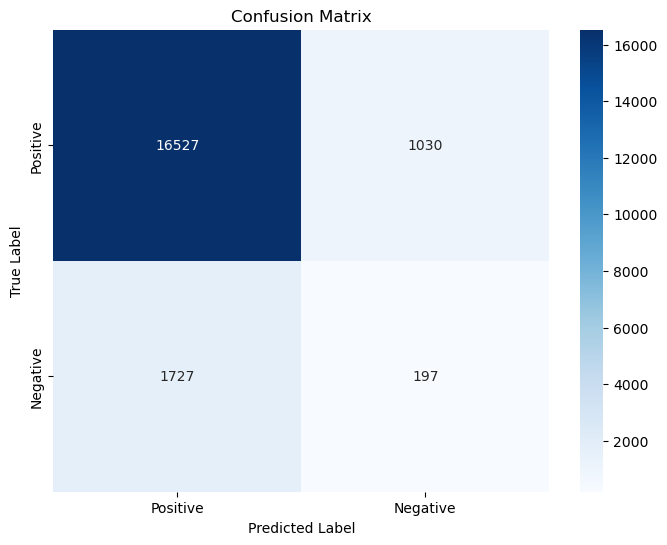

In [54]:
TP = calc_TP(classificated_test_data)
TN = calc_TN(classificated_test_data)
FP = calc_FP(classificated_test_data)
FN = calc_FN(classificated_test_data)

conf_matrix = np.array([[TP, FN],
                        [FP, TN]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Classified topics distribution across sampled data

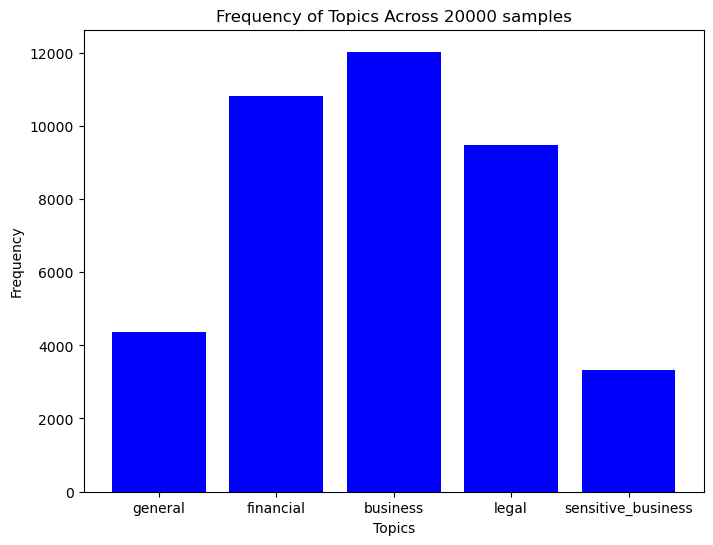

In [55]:
from collections import Counter

topic_counts = Counter()

for topics_set in test_data['topic']:
    topic_counts.update(topics_set)

topics_df = pd.DataFrame.from_dict(topic_counts, orient='index').reset_index()
topics_df = topics_df.rename(columns={'index': 'Topic', 0: 'Count'})

plt.figure(figsize=(8, 6))
plt.bar(topics_df['Topic'], topics_df['Count'], color='blue')

plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title(f'Frequency of Topics Across {test_data.shape[0]} samples')
plt.show()

# Plotting info from the personnel dataframe

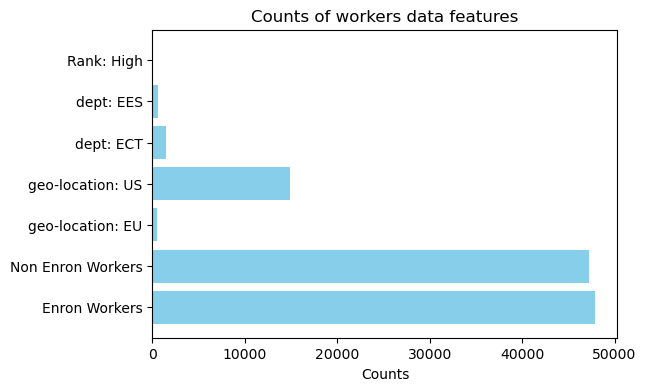

In [70]:
import matplotlib.pyplot as plt

# Calculate the conditions
isEnron_true_count = workers_data[workers_data['isEnron'] == True].shape[0]
isEnron_false_count = workers_data[workers_data['isEnron'] == False].shape[0]
gpe_eu_count = workers_data[workers_data['GPE'] == 'EU'].shape[0]
gpe_us_count = workers_data[workers_data['GPE'] == 'US'].shape[0]
dept_ect_count = workers_data[workers_data['dept'] == 'ECT'].shape[0]
dept_ees_count = workers_data[workers_data['dept'] == 'EES'].shape[0]
rank_high_count = workers_data[workers_data['Rank'] == 'High'].shape[0]

labels = ['Enron Workers', 'Non Enron Workers', 'geo-location: EU', 'geo-location: US', 'dept: ECT', 'dept: EES', 'Rank: High']
counts = [isEnron_true_count, isEnron_false_count, gpe_eu_count, gpe_us_count, dept_ect_count, dept_ees_count, rank_high_count]

# Creating the plot
plt.figure(figsize=(6, 4))
plt.barh(labels, counts, color='skyblue')
plt.xlabel('Counts')
plt.title('Counts of workers data features')
plt.show()

# Classification for group 8 dataframe

In [55]:
def prepare_pickle(pickle_path):
  group_df = pd.read_pickle(pickle_path)
  group_df = apply_content_analysis(group_df)
  group_df = apply_topic_modeling(group_df)
  return group_df

def classify_group_pickle(df, workers_df):
  global workers_data
  workers_data, res_df = workers_df.copy(), df.copy()
  violations = []

  for _, row in df.iterrows():
    workers_data = build_workers_data(pd.DataFrame([row]), workers_data)
    violations.append(check_rule_violations(row))

  res_df["violated_rules"] = violations
  res_df['verdict'] = res_df['violated_rules'].apply(lambda x: 'ALLOW' if not x else 'BLOCK')
  res_df = res_df.drop(["topic", "has_pii_qid", "email_content"], axis=1)
  return res_df

In [56]:
group_df = prepare_pickle("./student_group_8.pkl")
classified_group_df = classify_group_pickle(group_df, workers_data)
classified_group_df.to_csv("./classified_group_8_data.csv")

# Exposed API function

Loading the personnel data model for api function usage
- User must run th read_pickle command below for proper functionalities.

In [72]:
workers_data = pd.read_pickle("./workers_model.pkl")

In [114]:
def classify_mail(mail_content:  pd.core.series.Series) -> bool:
  mail_content = pd.DataFrame([mail_content])
  mail_content = apply_content_analysis(mail_content)
  mail_content = apply_topic_modeling(mail_content)
  mail_content = apply_classification(mail_content)

  if mail_content["violations"].iloc[0] == set():
    return True
  return False

In [115]:
test_row = None # PLACEHOLDER for row testing

classification_test = classify_mail(test_row)
classification_map = {True: "ALLOW", False: "BLOCK"}

print(f"based on our classification, the mail's verdict is: {classification_map[classification_test]}")

based on our classification, the mail's verdict is: ALLOW
